# Sample Inspector (Part I)
## Looking at keywords over time

In this notebook, we investigate how the digital sample compares to the 'universe' of book publications in the 19th century. Even though the Microsoft Digitised Books corpus is a rich collection, it remains unclear what is in there and what's not. Especially when one is interested in a specific topic, like 'machines', knowing what content we don't have digital access to is critical if we want to make sense and of findings built on such digital resources.

To understand the digital sample to the population of printed works, we compare the keywords in titles between these two levels. We show how to load and process data in Pandas, build a quick and efficient method to gauge and visualize the presence of a set of selected keywords in book titles over time.

In [ ]:
# first we need import all libraries and tools required in the rest of this notebook
%matplotlib inline
import json
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter, defaultdict

## Loading the data

Using Pandas, we load the metadata on the BL books collection and print the first three rows for inspection.

In [ ]:
metadata_blb = pd.read_csv(
    "https://bl.iro.bl.uk/downloads/e1be1324-8b1a-4712-96a7-783ac209ddef?locale=en",
    dtype={"BL record ID": "string"},
    parse_dates=False,
)
metadata_blb.head(3)

,BL record ID,Type of resource,Name,Dates associated with name,Type of name,Role,All names,Title,Variant titles,Series title,...,Date of publication,Edition,Physical description,Dewey classification,BL shelfmark,Topics,Genre,Languages,Notes,BL record ID for physical resource
0,014602826,Monograph,"Yearsley, Ann",1753-1806,person,NaN,"More, Hannah, 1745-1833 [person] ; Yearsley, A...",Poems on several occasions [With a prefatory l...,NaN,NaN,...,1786,Fourth edition MANUSCRIPT note,NaN,NaN,Digital Store 11644.d.32,NaN,NaN,English,NaN,3996603
1,014602830,Monograph,"A, T.",NaN,person,NaN,"Oldham, John, 1653-1683 [person] ; A, T. [person]",A Satyr against Vertue. (A poem: supposed to b...,NaN,NaN,...,1679,NaN,15 pages (4°),NaN,Digital Store 11602.ee.10. (2.),NaN,NaN,English,NaN,1143
2,014602831,Monograph,NaN,NaN,NaN,NaN,NaN,"The Aeronaut, a poem; founded almost entirely,...",NaN,NaN,...,1816,NaN,17 pages (8°),NaN,Digital Store 992.i.12. (3.),Dublin (Ireland),NaN,English,NaN,22782


## Parsing all of the titles for a year

Next, we process the titles in this dataframe: we create a `pd.Series` object in which we map a year to a long string that contains all the titles of books published in that year.

In [ ]:
# convert all titles to a string
metadata_blb["title_str"] = metadata_blb.Title.apply(lambda x: "".join([t for t in x]))
# in case of a date range select the first year
metadata_blb["Date of publication"] = metadata_blb["Date of publication"].apply(
    lambda x: str(x).split("-")[0]
)
# group all titles by year, i.e. for each year we concatenate all titles as one long string
titles_by_year_bl = metadata_blb.groupby("Date of publication")["title_str"].apply(
    " ".join
)
# slice the Series to retain only titles that fall within the target period
titles_by_year_bl = titles_by_year_bl["1800":"1899"]

These operations return a variable `titles_by_year_bl` of type `pd.Series` in which the index refers to the year of publication and the values are a concatenation of all titles

In [ ]:
titles_by_year_bl

Date of publication
1800    Egbert; or, The Suicide. A tale [In verse.] So...
1801    The Old Hag in a Red Cloak. A romance [In vers...
1802    Elegy to the memory of the late Duke of Bedfor...
1803    [Britons strike home.] Songs &c. in Britons st...
1804    The Sports of the Genii [Etchings from drawing...
                              ...                        
1895    A Few Verses The Ghais o' Dennilair: a legend ...
1896    Book of Word & Music of Humorous Songs, Burles...
1897    Altenglische Spruchweisheit, alt- und mittelen...
1898    A Vision. (Penny edition.) The Ballad of the W...
1899    Hawthorn and Lavender: songs and madrigals We ...
Name: title_str, Length: 100, dtype: object

In [ ]:
titles_by_year_bl["1800"][:200]

'Egbert; or, The Suicide. A tale [In verse.] Songs, Chorusses, etc, in the new pantomime of Harlequin Tour; or, the Dominion of Fancy, as performed at the Theatre Royal, Covent-Garden, etc A Journey to'

## Loading catalogue metadata

Then we load a .csv file which contains an export of the British Library Catalogue. For sure, the BL catalogue won't give us a complete list of all books in the 19th century, but at least it is converging to the universe of known printed works in this period. As a comparison and contextualisation tool, it helps us understand the contours and composition of the digital collection.

In [ ]:
metadata_cat = pd.read_csv(
    "https://bl.iro.bl.uk/downloads/e4bf0f74-2c64-4322-93c7-0dcc5e5246da?locale=en",
    dtype={"BL record ID": "string"},
)
metadata_cat.head(3)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (2,3,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,BL record ID,Type of resource,BNB number,ISBN,Name,Dates associated with name,Type of name,Role,All names,Title,...,Publisher,Date of publication,Edition,Physical description,Dewey classification,BL shelfmark,Topics,Genre,Languages,Notes
0,000000004,Monograph,NaN,NaN,NaN,NaN,NaN,NaN,"Carlbohm, Johan Arvid, printer [person]","Aabc [etc.] Jesus Vocales, eli äänelliset boks...",...,präntätty directörin J.A. Carlbohmin tykönä,1800,NaN,"16 unnumbered pages, 17 cm (8°)",NaN,12976.aa.3,Writing ; Reading ; Writing--Alphabets--Primer...,NaN,Finnish,"Finnish primer, beginning with the Lord's pray..."
1,000000006,Monograph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A che serve il Papa?,...,Tiberina,1889,NaN,"32 pages, 14 cm",NaN,3900.aaa.20. (4.),NaN,NaN,Italian,NaN
2,000000007,Monograph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A. for Apple [An illustrated alphabet.],...,Ward & Lock,1894,NaN,NaN,NaN,12811.h.70,NaN,NaN,NaN,NaN


### Parsing date ranges

Values in the `'Date of publication'` column sometimes refer to a date range instead of a specific year. To simplify things, we take the first year as the date of publication. Admittedly, this choice is questionable, and we encourage that you craft other solutions depending on your research interests.

In [ ]:
metadata_cat["Date of publication"].unique()

array(['1800', '1889', '1894', ..., '1855-1875', '1887-1937', '1893-1963'],
      dtype=object)

In [ ]:
metadata_cat["date"] = metadata_cat["Date of publication"].apply(
    lambda x: str(x).split("-")[0]
)

We also do the same for the BL Books collection

In [ ]:
metadata_blb["date"] = metadata_blb["Date of publication"].apply(
    lambda x: str(x).split("-")[0]
)

With its 5.1 billion tokens and close to 50k titles, the Microsoft Digitised Books is an impressive collection. However, it constitutes just 2.73% of all books printed in the 19th century. As a historian, the amount of information seems overwhelming, but one should realise it is still a small empirical basis when making claims about cultural evolution in the 19th century. 

In [ ]:
num_19thc_books_bl = len(
    metadata_blb[(metadata_blb.date >= "1800") & (metadata_blb.date < "1900")]
)
num_19thc_books_cat = len(
    metadata_cat[(metadata_cat.date >= "1800") & (metadata_cat.date < "1900")]
)
print("Number of 19thC works in the BL Books collection: ", num_19thc_books_bl)
print("Number of 19thC works in the Catologue: ", num_19thc_books_cat)
print(
    "The sample size is", round(num_19thc_books_bl / num_19thc_books_cat * 100, 2), "%"
)

Number of 19thC works in the BL Books collection:  46518
Number of 19thC works in the Catologue:  1686158
The sample size is 2.76 %



### Comparing our corpus to a wider collection 

Similar to what we did with BL Books metadata, we concatenate titles in the catalogue to one long string, one per year, and slice the `pd.Series` object.

In [ ]:
metadata_cat["Title"] = metadata_cat["Title"].astype(
    str
)  # convert all titles to strings
titles_by_year_cat = metadata_cat.groupby("date")["Title"].apply(
    " ".join
)  # group titles by year and join as one long string
titles_by_year_cat = titles_by_year_cat["1800":"1899"]  # slice the series

We established that the digital corpus constitutes only 2.76% of the population. To assess changes over time, we can visualize the sample size (as a percentage of the population) for each year.

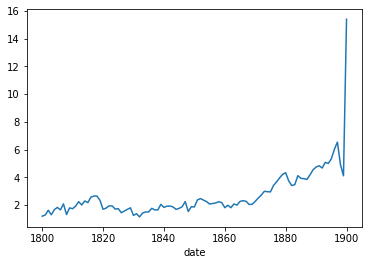

In [ ]:
a = metadata_cat.groupby("date")["Title"].count()["1800":"1900"]
b = metadata_blb.groupby("date")["title_str"].count()["1800":"1900"]
(b / a * 100).plot()

In the cells below, we turn to analysing and comparing the content of the titles. We repeat the following steps for both the BL Books metadata and catalogue information.
- We create a document-term matrix, where each row comprises the word counts for all titles in a specific year
- We compute the total word counts per year

We use the `CountVectorizer` object provided by `sklearn` which takes a list of texts as input and converts this to a document-term matrix. The `min_df` argument allows us to discard words that only appear once, thus avoiding that the matrix becomes too large.

In [ ]:
bl_counts = CountVectorizer(min_df=2)  # create a CountVectorizer object
bl_dtm = bl_counts.fit_transform(
    titles_by_year_bl
)  # fit the CountVectorizer on the titles
totals_bl = bl_dtm.sum(axis=1)
# sum row wise, i.e. totals for each year
totals_bl = np.squeeze(np.array(totals_bl))

In [ ]:
cat_counts = CountVectorizer(min_df=10)
cat_dtm = cat_counts.fit_transform(titles_by_year_cat)
totals_cat = cat_dtm.sum(axis=1)
totals_cat = np.squeeze(np.array(totals_cat))

By amending the `terms` variable you can select the keywords you want to investigate and compare between sample and population.

In [ ]:
terms = {"machinery", "machines", "machine", "engine", "engines"}

In [ ]:
terms_bl = list(terms.intersection(set(bl_counts.get_feature_names())))
print(
    "Plotting relative frequency for following words in BL Books titles:\n\t", terms_bl
)
terms_cat = list(terms.intersection(set(cat_counts.get_feature_names())))
print()
print(
    "Plotting relative frequency for following words in BL Catalogue titles:\n\t",
    terms_cat,
)

Plotting relative frequency for following words in BL Books titles:
	 ['machinery', 'machines', 'engines']

Plotting relative frequency for following words in BL Catalogue titles:
	 ['machine', 'machines', 'engines', 'machinery', 'engine']


In the code cell below, we first collect frequencies of the given query terms in the BL Books corpus (and sum all counts if more than one keyword is given). We divide the yearly absolute counts by the total number of words in titles to obtain yearly relative frequencies. We repeat the same procedure for the catalogue data.

Lastly, we plot the relative frequencies for both the BL Books (blue) and catalogue (orange), slight smoothing the timeline by showing the rolling mean.

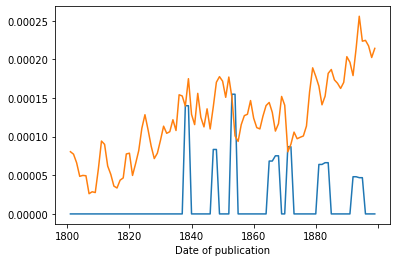

In [ ]:
idx_bl = [bl_counts.vocabulary_[term] for term in terms_bl]
if len(idx_bl) <= 1:
    counts_bl = np.squeeze(bl_dtm[:, idx_bl].toarray())
else:
    counts_bl = np.squeeze(bl_dtm[:, idx_bl].toarray()).sum(axis=1)

pd.Series(counts_bl / totals_bl, index=titles_by_year_bl.index).rolling(2).mean().plot()
idx_cat = [cat_counts.vocabulary_[term] for term in terms_cat]

if len(idx_cat) <= 1:
    counts_cat = np.squeeze(cat_dtm[:, idx_cat].toarray())
else:
    counts_cat = np.squeeze(cat_dtm[:, idx_cat].toarray()).sum(axis=1)

pd.Series(counts_cat / totals_cat).rolling(2).mean().plot()

## Fin.